In [42]:
!pip install boto3

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 205.5 MB/s eta 0:00:00


In [53]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable


In [69]:
!pip install -U kaleido

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 176.9 MB/s eta 0:00:0000:0100:01


In [1]:
#importing all libraries
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
import warnings
import boto3
warnings.filterwarnings('ignore')

2025-04-16 05:13:26.161702: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 05:13:26.824339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 05:13:26.824416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 05:13:26.967841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 05:13:27.259326: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 05:13:27.262186: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
def upload_file_to_s3(file_name, bucket_name, object_name=None):
    import boto3
    from botocore.exceptions import NoCredentialsError

    if object_name is None:
        object_name = f"Cloud_plots/{file_name.split('/')[-1]}"  # always prepends folder

    s3_client = boto3.client('s3')
    try:
        s3_client.upload_file(file_name, bucket_name, object_name)
        print(f"File '{file_name}' uploaded successfully to '{bucket_name}/{object_name}'")
        return True
    except FileNotFoundError:
        print("Error: The file was not found.")
    except NoCredentialsError:
        print("Error: AWS credentials not available.")
    except Exception as e:
        print(f"Error: {e}")
    return False
bucket_name = "x22249729-thesis-bucket"

In [4]:
#laoding dataset into dataframe
dataframe = pd.read_csv('Data/azure.csv')
dataframe.head()

timestamp        min cpu       max cpu       avg cpu
0  2017-01-01 00:00:00  715146.536821  2.223302e+06  1.229569e+06
1  2017-01-01 00:05:00  700473.840324  2.212393e+06  1.211322e+06
2  2017-01-01 00:10:00  705953.565850  2.213057e+06  1.206635e+06
3  2017-01-01 00:15:00  688383.073221  2.187572e+06  1.190369e+06
4  2017-01-01 00:20:00  688276.551033  2.183684e+06  1.180992e+06

In [5]:
#shape of dataset
dataframe.shape

(8640, 4)

In [6]:
#checking null values
dataframe.isna().sum()

timestamp    0
min cpu      0
max cpu      0
avg cpu      0
dtype: int64

In [7]:
#columns names
dataframe.columns

Index(['timestamp', 'min cpu', 'max cpu', 'avg cpu'], dtype='object')

In [8]:
#dtypes of all columns
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  8640 non-null   object 
 1   min cpu    8640 non-null   float64
 2   max cpu    8640 non-null   float64
 3   avg cpu    8640 non-null   float64
dtypes: float64(3), object(1)
memory usage: 270.1+ KB


In [9]:
#date columns is object converting to datetime format and extracting year and month columns
dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])
dataframe['Year'] = dataframe['timestamp'].dt.year
dataframe['Month'] = dataframe['timestamp'].dt.month
dataframe['Day'] = dataframe['timestamp'].dt.day
dataframe.head()

timestamp        min cpu       max cpu       avg cpu  Year  Month  \
0 2017-01-01 00:00:00  715146.536821  2.223302e+06  1.229569e+06  2017      1   
1 2017-01-01 00:05:00  700473.840324  2.212393e+06  1.211322e+06  2017      1   
2 2017-01-01 00:10:00  705953.565850  2.213057e+06  1.206635e+06  2017      1   
3 2017-01-01 00:15:00  688383.073221  2.187572e+06  1.190369e+06  2017      1   
4 2017-01-01 00:20:00  688276.551033  2.183684e+06  1.180992e+06  2017      1   

   Day  
0    1  
1    1  
2    1  
3    1  
4    1

In [10]:
#statistic of data
dataframe.describe()

timestamp       min cpu       max cpu       avg cpu    Year  \
count                 8640  8.640000e+03  8.640000e+03  8.640000e+03  8640.0   
mean   2017-01-15 23:57:30  7.075603e+05  2.205312e+06  1.215661e+06  2017.0   
min    2017-01-01 00:00:00  5.862266e+05  1.823027e+06  9.786379e+05  2017.0   
25%    2017-01-08 11:58:45  6.675541e+05  2.072256e+06  1.125854e+06  2017.0   
50%    2017-01-15 23:57:30  7.050560e+05  2.196693e+06  1.210631e+06  2017.0   
75%    2017-01-23 11:56:15  7.411543e+05  2.330497e+06  1.298056e+06  2017.0   
max    2017-01-30 23:55:00  1.151024e+06  3.529283e+06  1.821756e+06  2017.0   
std                    NaN  5.372051e+04  1.723607e+05  1.096154e+05     0.0   

        Month          Day  
count  8640.0  8640.000000  
mean      1.0    15.500000  
min       1.0     1.000000  
25%       1.0     8.000000  
50%       1.0    15.500000  
75%       1.0    23.000000  
max       1.0    30.000000  
std       0.0     8.655942

In [11]:
#again checking datatypes after converting to datetime
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  8640 non-null   datetime64[ns]
 1   min cpu    8640 non-null   float64       
 2   max cpu    8640 non-null   float64       
 3   avg cpu    8640 non-null   float64       
 4   Year       8640 non-null   int32         
 5   Month      8640 non-null   int32         
 6   Day        8640 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(3)
memory usage: 371.4 KB


In [12]:
# size of unique values in each column
for i in dataframe.columns:
  print(i,dataframe[i].unique().size)

timestamp 8640
min cpu 8640
max cpu 8640
avg cpu 8640
Year 1
Month 1
Day 30


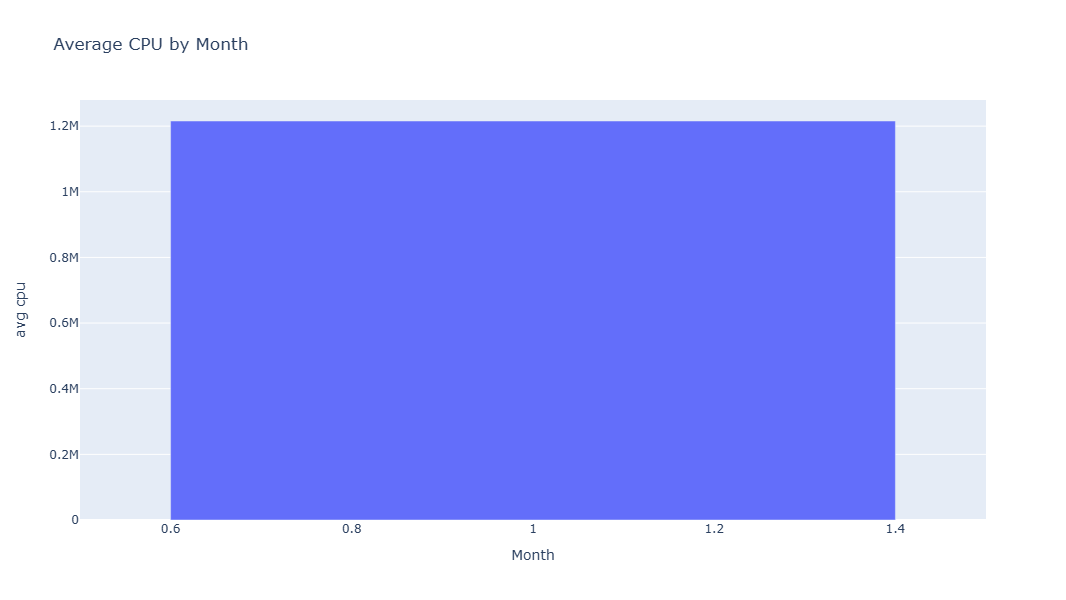

File './Cloud_plots/plot1.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/plot1.png'


True

In [13]:
#Month wise mean of avg cpu columns
# dataframe[['Month','avg cpu']].groupby(['Month']).mean().sort_values('Month').plot(kind='bar')
# plt.figure(figsize=(6, 6))
df_grouped = dataframe[['Month', 'avg cpu']].groupby('Month').mean().reset_index().sort_values('Month')
fig = px.bar(df_grouped, x='Month', y='avg cpu', title='Average CPU by Month')
fig.update_layout(
    width=1000,     
    height=600,    
)
# Show the interactive plot
fig.show()

# Save and upload
file_name = "./Cloud_plots/plot1.png"
fig.write_image(file_name)
upload_file_to_s3(file_name, bucket_name)

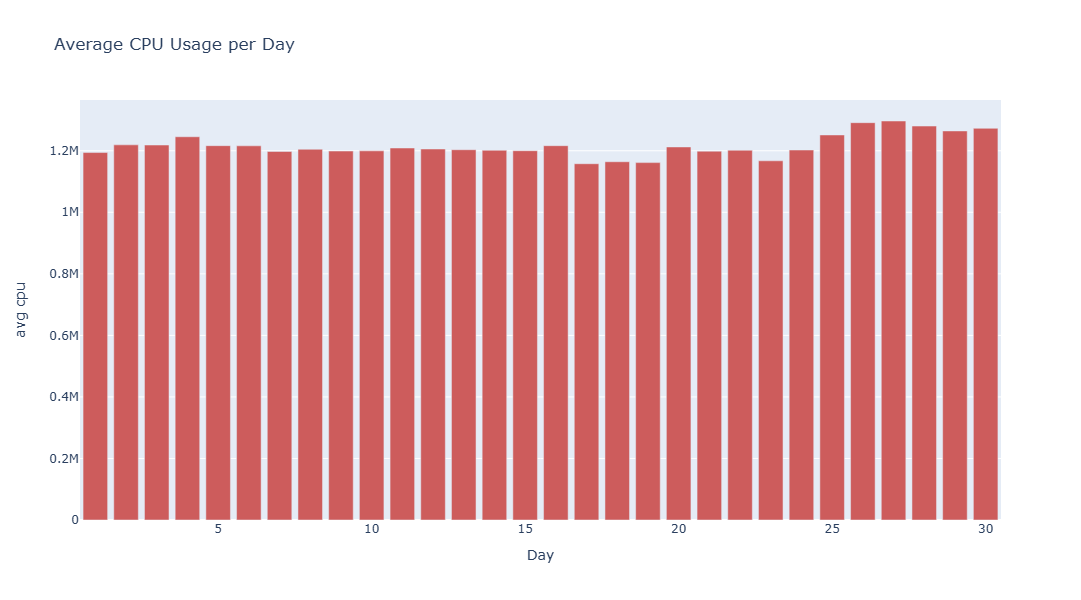

File './Cloud_plots/plot1.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/plot1.png'


True

In [14]:
# Day wise mean of avg cpu columns
# dataframe[['Day','avg cpu']].groupby(['Day']).mean().sort_values('Day').plot(kind='bar',figsize=(10,7),color='indianred')

# Prepare the data
df_grouped = dataframe[['Day', 'avg cpu']].groupby('Day').mean().reset_index().sort_values('Day')

# Create a Plotly bar chart
fig = px.bar(df_grouped, x='Day', y='avg cpu',
             title='Average CPU Usage per Day',
             color_discrete_sequence=['indianred'])
fig.update_layout(
    width=1000,     
    height=600,    
)
# Show the interactive plot
fig.show()

# Save and upload
file_name = "./Cloud_plots/plot1.png"
fig.write_image(file_name)

upload_file_to_s3(file_name, bucket_name)


In [15]:
data = dataframe.set_index('timestamp')
data = data[['min cpu', 'max cpu', 'avg cpu']]
data

min cpu       max cpu       avg cpu
timestamp                                                     
2017-01-01 00:00:00  715146.536821  2.223302e+06  1.229569e+06
2017-01-01 00:05:00  700473.840324  2.212393e+06  1.211322e+06
2017-01-01 00:10:00  705953.565850  2.213057e+06  1.206635e+06
2017-01-01 00:15:00  688383.073221  2.187572e+06  1.190369e+06
2017-01-01 00:20:00  688276.551033  2.183684e+06  1.180992e+06
...                            ...           ...           ...
2017-01-30 23:35:00  728008.315162  2.233166e+06  1.242129e+06
2017-01-30 23:40:00  737452.951022  2.219408e+06  1.235937e+06
2017-01-30 23:45:00  742153.686192  2.188120e+06  1.224276e+06
2017-01-30 23:50:00  725404.574579  2.156483e+06  1.201533e+06
2017-01-30 23:55:00  718923.039580  2.190483e+06  1.207906e+06

[8640 rows x 3 columns]

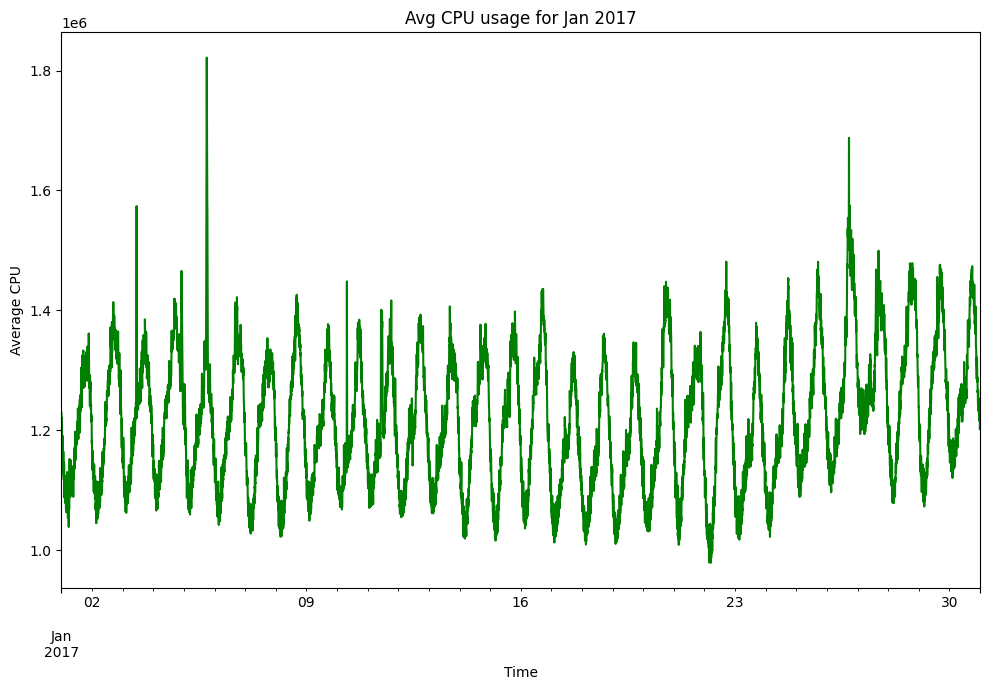

File './Cloud_plots/avg_cpu_jan2017.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/avg_cpu_jan2017.png'


True

In [16]:
#line plot of avg cpu column
# plt.figure(figsize=(10,7))
# data['avg cpu'].plot(color='green')
# plt.title("Avg Cpu usage for jan 2017")
# plt.show()
plt.figure(figsize=(10, 7))
data['avg cpu'].plot(color='green')
plt.title("Avg CPU usage for Jan 2017")
plt.xlabel("Time")
plt.ylabel("Average CPU")
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot
file_name = "./Cloud_plots/avg_cpu_jan2017.png"
plt.savefig(file_name)
plt.close()
upload_file_to_s3(file_name, bucket_name)

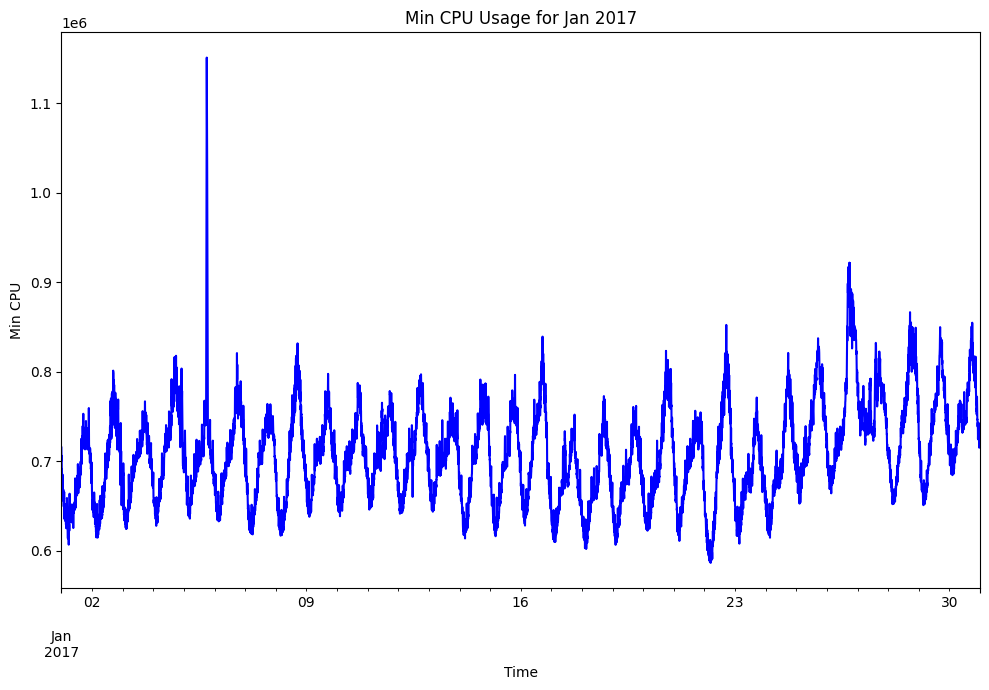

File './Cloud_plots/min_cpu_jan2017.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/min_cpu_jan2017.png'


True

In [17]:
#line plot of min cpu column
# plt.figure(figsize=(10,7))
# data['min cpu'].plot()
# plt.title("Min Cpu usage for jan 2017")
# plt.show()
plt.figure(figsize=(10, 7))
data['min cpu'].plot(color='blue')
plt.title("Min CPU Usage for Jan 2017")
plt.xlabel("Time")
plt.ylabel("Min CPU")
plt.tight_layout()
plt.show()
file_name = "./Cloud_plots/min_cpu_jan2017.png"
plt.savefig(file_name)
plt.close()

upload_file_to_s3(file_name, bucket_name)

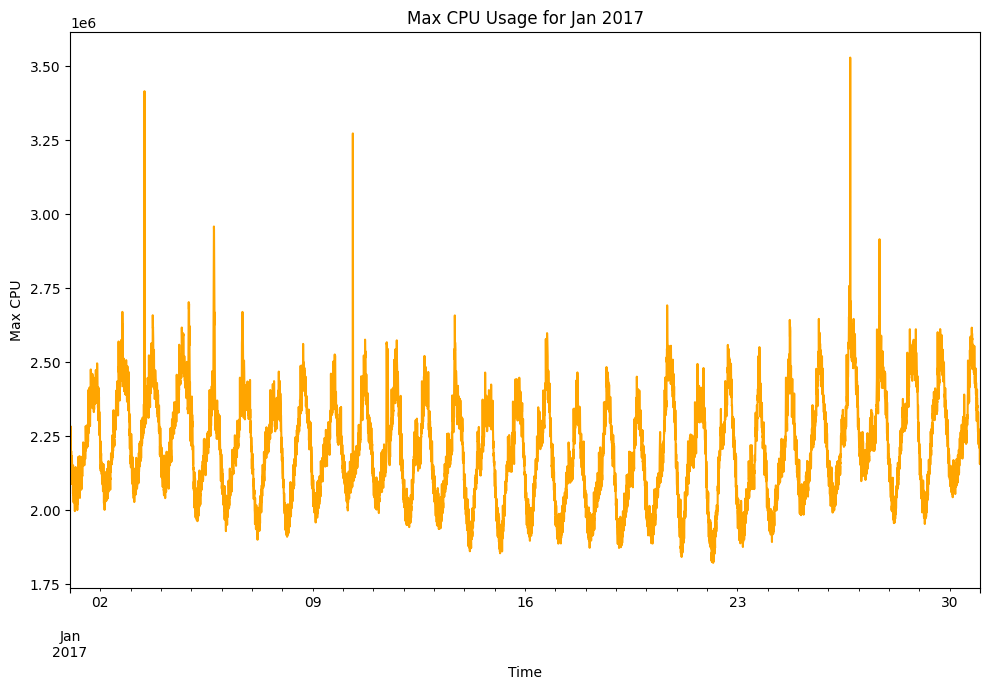

File './Cloud_plots/max_cpu_jan2017.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/max_cpu_jan2017.png'


True

In [18]:
#line plot of max cpu column
# plt.figure(figsize=(10,7))
# data['max cpu'].plot(color='orange')
# plt.title("Max Cpu usage for jan 2017")
plt.figure(figsize=(10, 7))
data['max cpu'].plot(color='orange')
plt.title("Max CPU Usage for Jan 2017")
plt.xlabel("Time")
plt.ylabel("Max CPU")
plt.tight_layout()
plt.show()
file_name = "./Cloud_plots/max_cpu_jan2017.png"
plt.savefig(file_name)
plt.close()

upload_file_to_s3(file_name, bucket_name)


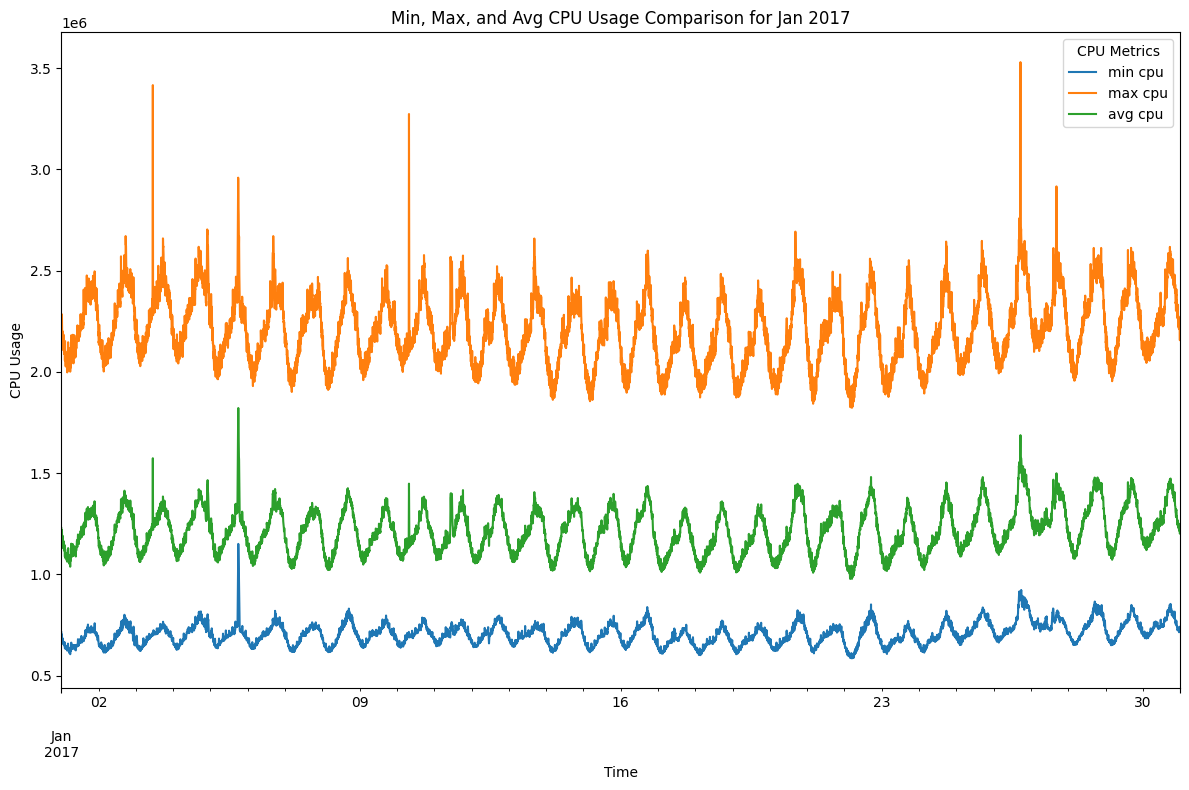

File './Cloud_plots/cpu_comparison_jan2017.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/cpu_comparison_jan2017.png'


True

In [19]:
#line plot of all columns
# data.plot(figsize=(12, 8))
# plt.title("Min, Max and Avg comparsion usage for jan 2017")
# plt.show()
data.plot(figsize=(12, 8))
plt.title("Min, Max, and Avg CPU Usage Comparison for Jan 2017")
plt.xlabel("Time")
plt.ylabel("CPU Usage")
plt.legend(title="CPU Metrics")
plt.tight_layout()
plt.show()
file_name = "./Cloud_plots/cpu_comparison_jan2017.png"
plt.savefig(file_name)
plt.close()

upload_file_to_s3(file_name, bucket_name)


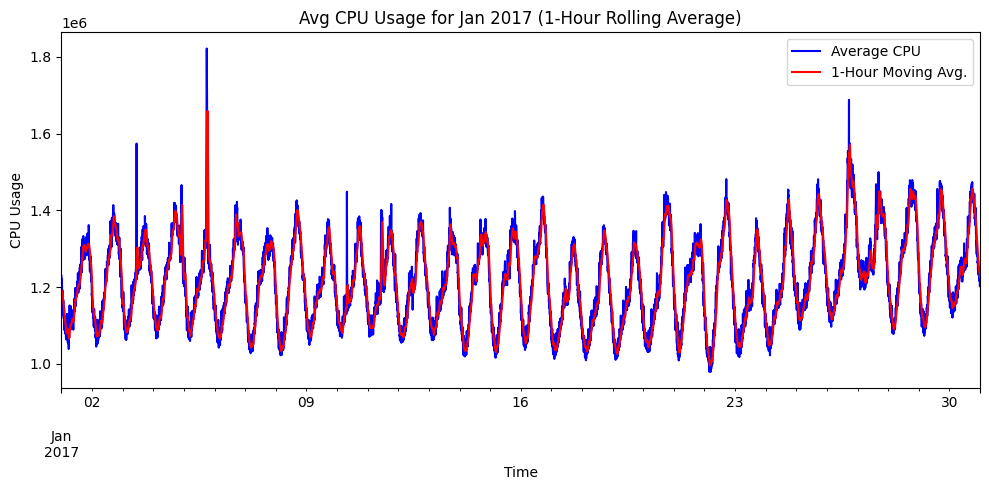

File './Cloud_plots/cpu_comparison_jan2017.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/cpu_comparison_jan2017.png'


True

In [20]:
#window rolling
plt.figure(figsize=(10, 5))

# Plot original avg CPU
data['avg cpu'].plot(label='Average CPU', color='blue')

# Plot 1-hour moving average
data['avg cpu'].rolling(window=12).mean().plot(label='1-Hour Moving Avg.', color='red')

# Titles and legend
plt.title("Avg CPU Usage for Jan 2017 (1-Hour Rolling Average)")
plt.xlabel("Time")
plt.ylabel("CPU Usage")
plt.legend()
plt.tight_layout()
plt.show()

upload_file_to_s3(file_name, bucket_name)

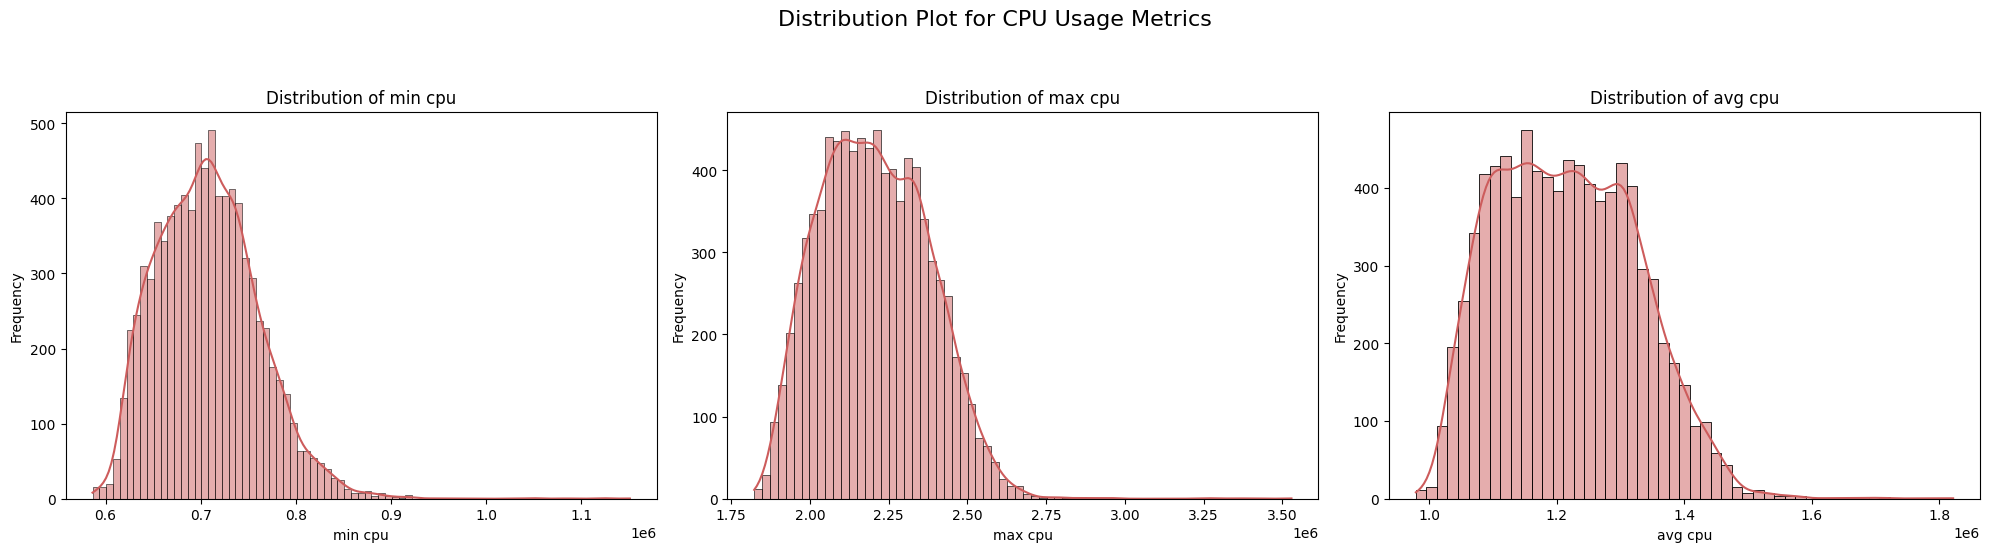

File './Cloud_plots/cpu_distplot_jan2017.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/cpu_distplot_jan2017.png'


True

In [21]:
#distanceplot
plt.figure(figsize=(20, 10))
plt.suptitle("Distribution Plot for CPU Usage Metrics", fontsize=16)

# Loop through each column and plot its distribution
for i, col in enumerate(data.columns):
    plt.subplot(2, 3, i + 1)  # Adjust depending on number of columns
    sns.histplot(data[col], kde=True, color='indianred')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
plt.show()
file_name = "./Cloud_plots/cpu_distplot_jan2017.png"
plt.savefig(file_name)
plt.close()

upload_file_to_s3(file_name, bucket_name)


In [22]:
data2 = data[['avg cpu']]

In [23]:
data1 = data.reset_index()['avg cpu']
data1

0       1.229569e+06
1       1.211322e+06
2       1.206635e+06
3       1.190369e+06
4       1.180992e+06
            ...     
8635    1.242129e+06
8636    1.235937e+06
8637    1.224276e+06
8638    1.201533e+06
8639    1.207906e+06
Name: avg cpu, Length: 8640, dtype: float64

In [24]:
scaler=MinMaxScaler(feature_range=(0,1))
data1=scaler.fit_transform(np.array(data1).reshape(-1,1))

In [25]:
print(data1)

[[0.29762311]
 [0.27598004]
 [0.27042116]
 ...
 [0.29134424]
 [0.2643694 ]
 [0.27192837]]


In [26]:
training_size=int(len(data1)*0.90)
test_size=len(data1)-training_size
train_data,test_data=data1[0:training_size,:],data1[training_size:len(data1),:1]


In [27]:
training_size,test_size

(7776, 864)

In [28]:
train_data

array([[0.29762311],
       [0.27598004],
       [0.27042116],
       ...,
       [0.2777631 ],
       [0.2741466 ],
       [0.27518731]])

In [29]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [30]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 12
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [31]:
print(X_train.shape)
print(y_train.shape)

(7763, 12)
(7763,)


In [32]:
print(X_test.shape)
print(y_test.shape)

(851, 12)
(851,)


#Machine Learning Models

#Decision Tree Regressor

In [33]:
dtr_model = DecisionTreeRegressor(max_depth=2)
dtr_model.fit(X_train, y_train)
dtr_model.predict(X_test)
predicted = dtr_model.predict(X_test)
print(dtr_model.score(X_test, y_test))

0.8661293319861587


In [34]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-2 Score :', metrics.r2_score(y_test, predicted))

predicted_value = scaler.inverse_transform(predicted.reshape(-1, 1))
real_value = scaler.inverse_transform(y_test.reshape(-1, 1))

outputdf = pd.DataFrame({
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
}, index = data.index[-len(real_value): ])
outputdf.head()

Root Mean Squared Error: 0.048067551424224884
R-2 Score : 0.8661293319861587


Real     Predicted
timestamp                                      
2017-01-28 01:05:00  1.187498e+06  1.172015e+06
2017-01-28 01:10:00  1.160023e+06  1.172015e+06
2017-01-28 01:15:00  1.154472e+06  1.172015e+06
2017-01-28 01:20:00  1.148612e+06  1.172015e+06
2017-01-28 01:25:00  1.140325e+06  1.172015e+06

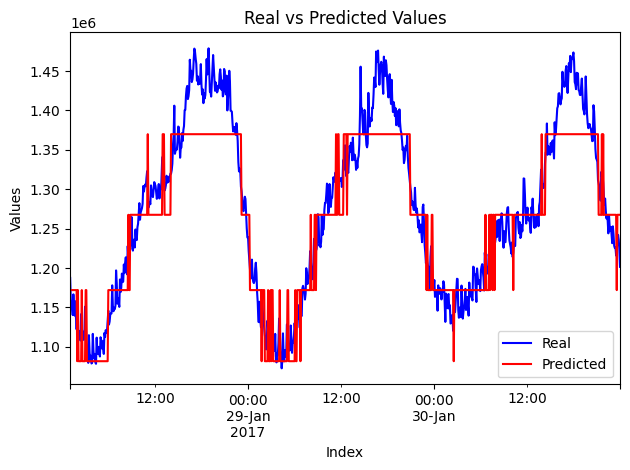

File './Cloud_plots/real_vs_predicted.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/real_vs_predicted.png'


True

In [35]:
outputdf.plot(title="Real vs Predicted Values", color=['blue', 'red'])

# Labels and title
plt.xlabel('Index')
plt.ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()
file_name = "./Cloud_plots/real_vs_predicted.png"
plt.savefig(file_name)
plt.close()

upload_file_to_s3(file_name, bucket_name)


#Gradient Boosting Regressor

In [36]:
gbr_model = GradientBoostingRegressor(n_estimators=18)
gbr_model.fit(X_train, y_train)
gbr_model.predict(X_test)
predicted = gbr_model.predict(X_test)
print(gbr_model.score(X_test, y_test))

0.9399626649824874


In [37]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-2 Score :', metrics.r2_score(y_test, predicted))

predicted_value = scaler.inverse_transform(predicted.reshape(-1, 1))
real_value = scaler.inverse_transform(y_test.reshape(-1, 1))

outputdf = pd.DataFrame({
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
}, index = data.index[-len(real_value): ])
outputdf.head()

Root Mean Squared Error: 0.03218992667714558
R-2 Score : 0.9399626649824874


Real     Predicted
timestamp                                      
2017-01-28 01:05:00  1.187498e+06  1.205037e+06
2017-01-28 01:10:00  1.160023e+06  1.189597e+06
2017-01-28 01:15:00  1.154472e+06  1.171273e+06
2017-01-28 01:20:00  1.148612e+06  1.164359e+06
2017-01-28 01:25:00  1.140325e+06  1.162000e+06

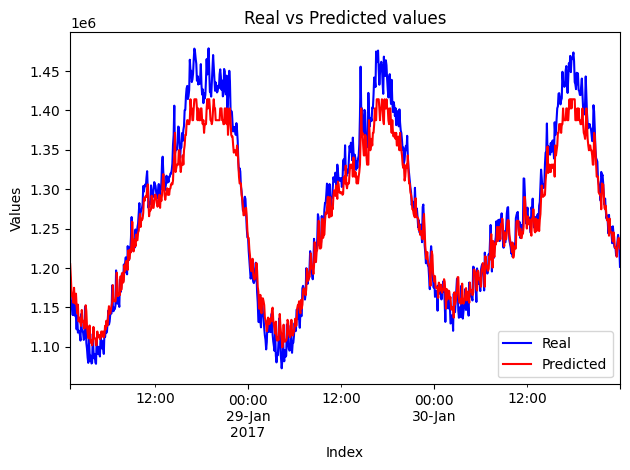

File './Cloud_plots/real_vs_predicted.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/real_vs_predicted.png'


True

In [38]:
outputdf.plot(title = "Real vs Predicted values", color=['blue', 'red'])
# Labels and title
plt.xlabel('Index')
plt.ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()
file_name = "./Cloud_plots/real_vs_predicted.png"
plt.savefig(file_name)
plt.close()

upload_file_to_s3(file_name, bucket_name)

#Deep learning models

In [39]:
# reshape input to be [samples, time steps, features] which is required for deep learning model
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#LSTM Model

In [40]:
#lstm model
model = Sequential()
model.add(LSTM(units=12,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=9, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=9))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 12)            672       
                                                                 
 dropout (Dropout)           (None, 12, 12)            0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 9)             792       
                                                                 
 dropout_1 (Dropout)         (None, 12, 9)             0         
                                                                 
 lstm_2 (LSTM)               (None, 9)                 684       
                                                                 
 dropout_2 (Dropout)         (None, 9)                 0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [43]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=128,verbose=1)

Epoch 1/20
61/61 [==============================] - 6s 29ms/step - loss: 0.0162 - val_loss: 0.0037
Epoch 2/20
61/61 [==============================] - 1s 14ms/step - loss: 0.0062 - val_loss: 0.0015
Epoch 3/20
61/61 [==============================] - 1s 14ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 4/20
61/61 [==============================] - 1s 14ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 5/20
61/61 [==============================] - 1s 14ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 6/20
61/61 [==============================] - 1s 14ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 7/20
61/61 [==============================] - 1s 14ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 8/20
61/61 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 9/20
61/61 [==============================] - 1s 14ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 10/20
61/61 [==============================] - 1s 14ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 11/

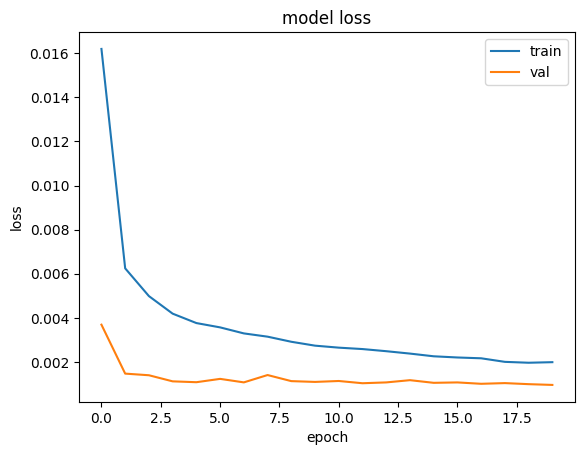

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

In [45]:
model.evaluate(X_test, y_test)
predicted = model.predict(X_test)

27/27 [==============================] - 1s 4ms/step


In [46]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-Score :', metrics.r2_score(y_test, predicted))

predicted_value = scaler.inverse_transform(predicted)
real_value = scaler.inverse_transform(y_test.reshape(-1, 1))

outputdf = pd.DataFrame({
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
}, index = data.index[-len(real_value): ])
outputdf.head()

Root Mean Squared Error: 0.03103256695706811
R-Score : 0.9442022311339945


Real    Predicted
timestamp                                     
2017-01-28 01:05:00  1.187498e+06  1185158.875
2017-01-28 01:10:00  1.160023e+06  1185301.875
2017-01-28 01:15:00  1.154472e+06  1185274.875
2017-01-28 01:20:00  1.148612e+06  1184023.750
2017-01-28 01:25:00  1.140325e+06  1181897.000

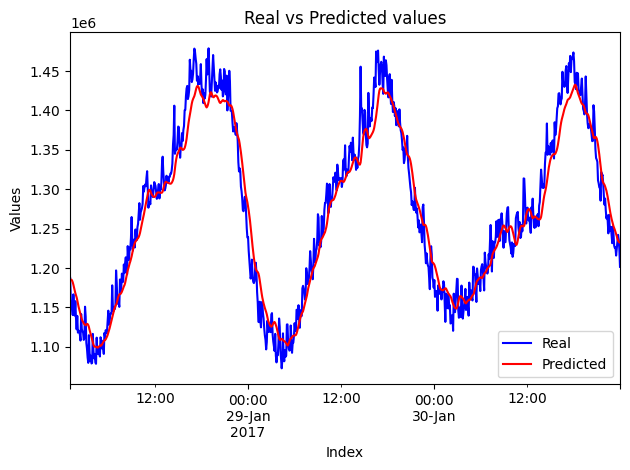

File './Cloud_plots/real_vs_predicted.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/real_vs_predicted.png'


True

In [47]:
outputdf.plot(title = "Real vs Predicted values", color=['blue', 'red'])
# Labels and title
plt.xlabel('Index')
plt.ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()
file_name = "./Cloud_plots/real_vs_predicted.png"
plt.savefig(file_name)
plt.close()

upload_file_to_s3(file_name, bucket_name)

#BILSTM Model

In [48]:
#bilstm model
model = Sequential()
model.add(Bidirectional(LSTM(units=32, input_shape=(X_train.shape[1], 1),return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

model.compile(optimizer='adam',loss='mean_squared_error')

In [49]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=128,verbose=1)

Epoch 1/20
61/61 [==============================] - 9s 48ms/step - loss: 0.0259 - val_loss: 0.0022
Epoch 2/20
61/61 [==============================] - 1s 24ms/step - loss: 0.0019 - val_loss: 9.7483e-04
Epoch 3/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0018 - val_loss: 8.1220e-04
Epoch 4/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 8.7618e-04
Epoch 5/20
61/61 [==============================] - 1s 24ms/step - loss: 0.0015 - val_loss: 7.5599e-04
Epoch 6/20
61/61 [==============================] - 2s 25ms/step - loss: 0.0015 - val_loss: 8.1898e-04
Epoch 7/20
61/61 [==============================] - 2s 25ms/step - loss: 0.0014 - val_loss: 6.0781e-04
Epoch 8/20
61/61 [==============================] - 1s 24ms/step - loss: 0.0012 - val_loss: 6.6765e-04
Epoch 9/20
61/61 [==============================] - 1s 24ms/step - loss: 0.0012 - val_loss: 5.4463e-04
Epoch 10/20
61/61 [==============================] - 1s 24ms/step - loss: 0.0

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 12, 64)            8704      
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 12, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 12, 32)            12416     
                                                                 
 dropout_4 (Dropout)         (None, 12, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                      

In [51]:
# plot_model(model, to_file='/content/drive/MyDrive/cpu_utilisation_azure/model_plot_bilstm.png', show_shapes=True, show_layer_names=True)

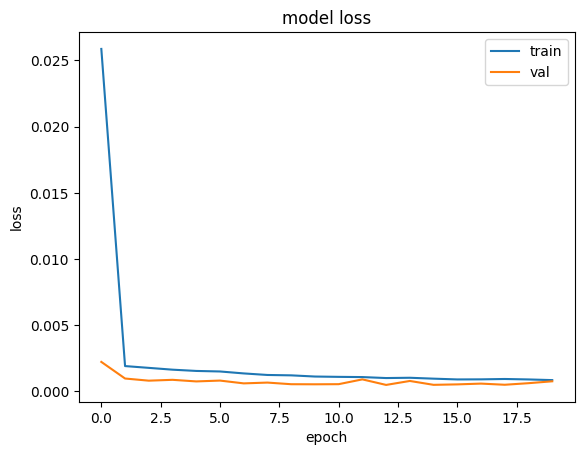

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

In [53]:
model.evaluate(X_test, y_test)
predicted = model.predict(X_test)

27/27 [==============================] - 1s 4ms/step


In [54]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-Score :', metrics.r2_score(y_test, predicted))

predicted_value = scaler.inverse_transform(predicted)
real_value = scaler.inverse_transform(y_test.reshape(-1, 1))

outputdf = pd.DataFrame({
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
}, index = data.index[-len(real_value): ])
outputdf.head()

Root Mean Squared Error: 0.027650840677619654
R-Score : 0.9557005727740955


Real    Predicted
timestamp                                     
2017-01-28 01:05:00  1.187498e+06  1182329.125
2017-01-28 01:10:00  1.160023e+06  1183866.375
2017-01-28 01:15:00  1.154472e+06  1176524.375
2017-01-28 01:20:00  1.148612e+06  1169058.500
2017-01-28 01:25:00  1.140325e+06  1161419.625

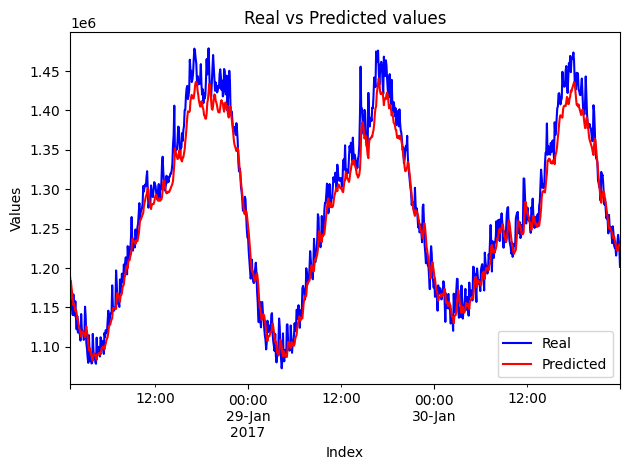

File './Cloud_plots/real_vs_predicted.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/real_vs_predicted.png'


True

In [55]:
outputdf.plot(title = "Real vs Predicted values", color=['blue', 'red'])
# Labels and title
plt.xlabel('Index')
plt.ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()
file_name = "./Cloud_plots/real_vs_predicted.png"
plt.savefig(file_name)
plt.close()

upload_file_to_s3(file_name, bucket_name)

# Multihead bilstm


In [56]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Concatenate

# Input layer
input_layer = Input(shape=(X_train.shape[1], 1))

# === BiLSTM Head 1 ===
head1 = Bidirectional(LSTM(32, return_sequences=True))(input_layer)
head1 = Dropout(0.2)(head1)
head1 = LSTM(32, return_sequences=True)(head1)
head1 = Dropout(0.2)(head1)
head1 = LSTM(32)(head1)
head1 = Dropout(0.2)(head1)

# === BiLSTM Head 2 ===
head2 = Bidirectional(LSTM(32, return_sequences=True))(input_layer)
head2 = Dropout(0.2)(head2)
head2 = LSTM(32, return_sequences=True)(head2)
head2 = Dropout(0.2)(head2)
head2 = LSTM(32)(head2)
head2 = Dropout(0.2)(head2)

# === BiLSTM Head 3 (different configuration) ===
head3 = Bidirectional(LSTM(16, return_sequences=True))(input_layer)
head3 = Dropout(0.2)(head3)
head3 = LSTM(16)(head3)
head3 = Dropout(0.2)(head3)

# === Merge all heads ===
merged = Concatenate()([head1, head2, head3])

# === Dense layers ===
dense = Dense(32, kernel_initializer='uniform', activation='tanh')(merged)
output = Dense(1, kernel_initializer='uniform', activation='linear')(dense)

# === Compile model ===
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 1)]              0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 12, 64)               8704      ['input_1[0][0]']             
 onal)                                                                                            
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 12, 64)               8704      ['input_1[0][0]']             
 onal)                                                                                            
                                                                                              

In [57]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=128,verbose=1)

Epoch 1/20
61/61 [==============================] - 21s 107ms/step - loss: 0.0193 - val_loss: 0.0012
Epoch 2/20
61/61 [==============================] - 3s 55ms/step - loss: 0.0015 - val_loss: 8.6963e-04
Epoch 3/20
61/61 [==============================] - 3s 54ms/step - loss: 0.0014 - val_loss: 7.8381e-04
Epoch 4/20
61/61 [==============================] - 3s 54ms/step - loss: 0.0013 - val_loss: 7.3124e-04
Epoch 5/20
61/61 [==============================] - 3s 55ms/step - loss: 0.0012 - val_loss: 7.0367e-04
Epoch 6/20
61/61 [==============================] - 3s 56ms/step - loss: 0.0011 - val_loss: 7.3323e-04
Epoch 7/20
61/61 [==============================] - 3s 55ms/step - loss: 0.0011 - val_loss: 6.1280e-04
Epoch 8/20
61/61 [==============================] - 3s 55ms/step - loss: 0.0011 - val_loss: 8.4942e-04
Epoch 9/20
61/61 [==============================] - 3s 55ms/step - loss: 0.0010 - val_loss: 5.8686e-04
Epoch 10/20
61/61 [==============================] - 3s 55ms/step - loss: 9

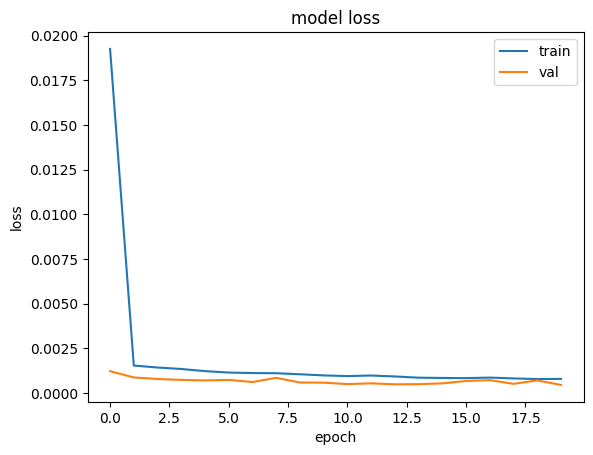

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

In [59]:
model.evaluate(X_test, y_test)
predicted = model.predict(X_test)

27/27 [==============================] - 3s 9ms/step


In [60]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-Score :', metrics.r2_score(y_test, predicted))

predicted_value = scaler.inverse_transform(predicted)
real_value = scaler.inverse_transform(y_test.reshape(-1, 1))

outputdf = pd.DataFrame({
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
}, index = data.index[-len(real_value): ])
outputdf.head()

Root Mean Squared Error: 0.021236800770578802
R-Score : 0.9738687841734687


Real    Predicted
timestamp                                     
2017-01-28 01:05:00  1.187498e+06  1188485.875
2017-01-28 01:10:00  1.160023e+06  1189957.750
2017-01-28 01:15:00  1.154472e+06  1182283.625
2017-01-28 01:20:00  1.148612e+06  1174682.500
2017-01-28 01:25:00  1.140325e+06  1167086.125

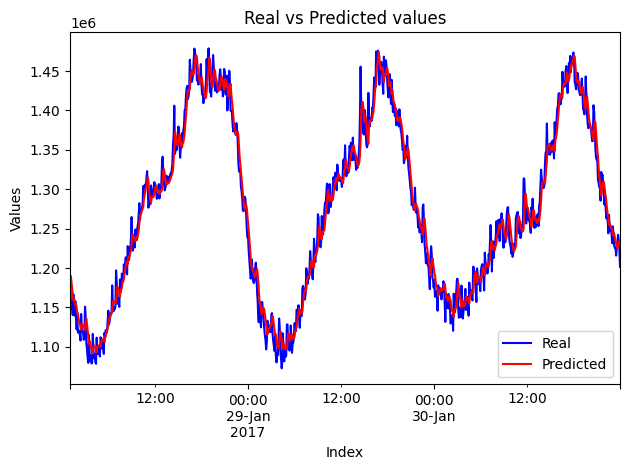

File './Cloud_plots/real_vs_predicted.png' uploaded successfully to 'x22249729-thesis-bucket/Cloud_plots/real_vs_predicted.png'


True

In [61]:
outputdf.plot(title = "Real vs Predicted values", color=['blue', 'red'])
# Labels and title
plt.xlabel('Index')
plt.ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()
file_name = "./Cloud_plots/real_vs_predicted.png"
plt.savefig(file_name)
plt.close()

upload_file_to_s3(file_name, bucket_name)